# OMXS30 Exploration

## Download the data of the last 5 years and plot the relative gain
The data is downloaded using yahoo finance, I ensured that the prices match the one on Avanza (the close price).

In [1]:
tickers = [
    "0P0000K9E7.ST",
    "0P0001QD8L.ST",
    "0P0001EORX.ST",
    "0P00000LST.ST",
    "0P0001QZW9.ST",
    "0P00000K17.ST",
    "0P0001QKMO.ST",
    "0P0001BMN5.ST",
    "0P00000L2Q.ST",
    "0P0000RZ2H",
    "0P0001KW2U.ST",
    "0P00000D6I.F",
    "0P00000I87.ST",
    "0P00011S7C.ST",
    "0P00000K48.ST",
    "0P00000L2Y.ST",
    "0P00000T7M.ST",
    "0P0001ECQR.ST",
    "0P0001BM0Y.ST",
    "0P00018OKM.ST",
    "0P000151K0.F",
    "0P00000FYR.ST",
    "0P00000EXD.ST",
    "0P0001F3XN.ST",
    "0P00000HMU.ST",
    "0P00017TAQ.ST",
    "0P0000ULAP.ST",
    "0P0000I3KB.ST",
    "0P00015E1I.F",
    "0P0001EE8J.ST",
    "0P00000FYN.ST",
    "0P00005U1J.ST",
    "0P00000EE2.F",
    "0P0001C30I.ST",
    "0P0000NC0M.ST",
    "0P0001FU42.ST",
    "0P0001PSHW.ST",
    "0P0001N9OB.ST",
    "0P0001OD91.ST",
    "0P00000LEI.ST",
    "0P00000MDL.F",
    "0P0001L9YZ.ST",
    "0P0001L9Z1.ST",
    "0P0001580F.ST",
    "0P00000IAJ.ST",
    "0P0001R7BB.ST",
    "0P0001FIKR.ST",
    "0P00016KIA.ST",
    "0P00011HBY.IR",
    "0P00002BUP",
    "0P0001P9AO",
    "0P0000RYCW.ST",
    "0P00017TAO.ST",
    "0P00019QOC.ST",
    "0P00019D0Y.ST",
    "0P0001NZN6.ST",
    "0P0001Q6FG.ST",
    "0P00018N0G.ST",
    "0P00000F92.ST",
    "0P00013NP8.ST",
    "0P0001Q77I.F",
    "0P0001IVD1.ST",
]
len(tickers)

indices = [
    "^OMX",
    "^DJI",
    "^IXIC",
    "^GSPC",
    "^FCHI",
]

tickers += indices

from data.loader import DataLoader, DataLoaderConfig
import logging
import datetime
import pandas as pd
logging.basicConfig(level=logging.INFO)
loader = DataLoader(DataLoaderConfig(tickers=tickers))

def get_data(ticker=tickers+indices):
    return loader.get_dataframe(
        ticker,
        columns='Close',
        start='2018-09-01',
        end='2023-09-01',
        fillna=True,
        dropna=True,
    )

data = get_data()


data.head()

INFO:data.loader:Dropping columns: "[]"


,0P0000K9E7.ST_Close,0P0001QD8L.ST_Close,0P0001EORX.ST_Close,0P00000LST.ST_Close,0P0001QZW9.ST_Close,0P00000K17.ST_Close,0P0001QKMO.ST_Close,0P0001BMN5.ST_Close,0P00000L2Q.ST_Close,0P0000RZ2H_Close,...,0P00018N0G.ST_Close,0P00000F92.ST_Close,0P00013NP8.ST_Close,0P0001Q77I.F_Close,0P0001IVD1.ST_Close,^OMX_Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^FCHI_Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-14,618.269226,100.0,142.137604,190.707001,100.0,259.470001,100.0,177.777100,8799.752930,92.980003,...,195.798706,15.15,241.776703,99.389999,144.690002,2096.439941,32945.238281,12581.219727,4173.109863,6369.939941
2022-03-15,617.871704,100.0,144.407196,193.627304,100.0,258.760010,100.0,177.777100,8799.752930,92.309998,...,193.268097,15.12,238.687698,99.389999,148.720001,2085.080078,33544.339844,12948.620117,4262.450195,6355.000000
2022-03-17,624.106995,100.0,146.102097,198.053406,100.0,261.489990,100.0,184.252899,8799.752930,100.110001,...,202.284698,15.45,245.931503,99.389999,150.369995,2159.000000,34480.761719,13614.780273,4411.669922,6612.520020
2022-03-18,635.856384,100.0,147.253601,200.208298,100.0,264.959991,100.0,186.923294,9267.802734,103.949997,...,204.304993,15.80,247.365799,99.389999,152.250000,2178.820068,34754.929688,13893.839844,4463.120117,6620.240234
2022-03-21,642.873474,100.0,147.244095,200.243805,100.0,266.510010,100.0,186.514297,9312.735352,103.410004,...,204.531906,15.90,250.619095,99.389999,152.110001,2181.050049,34552.988281,13838.459961,4461.180176,6582.330078


# Random experiments

#### Compute the support and resistance

INFO:data.loader:Dropping columns: "[]"
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:531: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend.append(([Idxs[x], Idxs[y], Idxs[z]], get_bestfit3(Idxs[x], h[Idxs[x]], Idxs[y], h[Idxs[y]], Idxs[z], h[Idxs[z]])))
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:655: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = get_bestfit([(p, h[p]) for p in CurIdxs])
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:678: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, inte

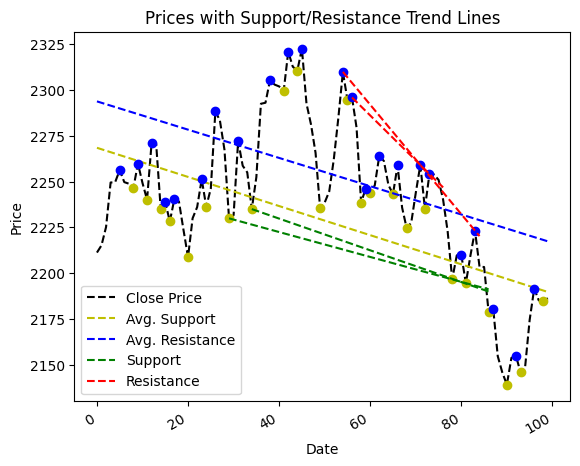

/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:538: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:548: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = get_bestfit([(p, h[p]) for p in CurIdxs])


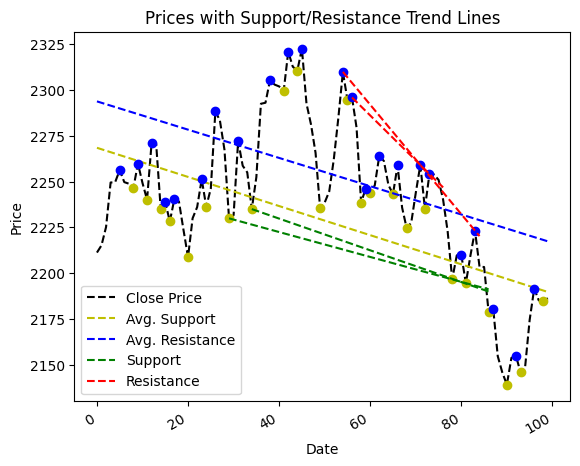

/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acc, theta, d = hough_points([(x, int((h[x] - m) * scl)) for x in Idxs], mx, len_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5))
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image[int((h[x] - m) * scl), x] = 255
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:572: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

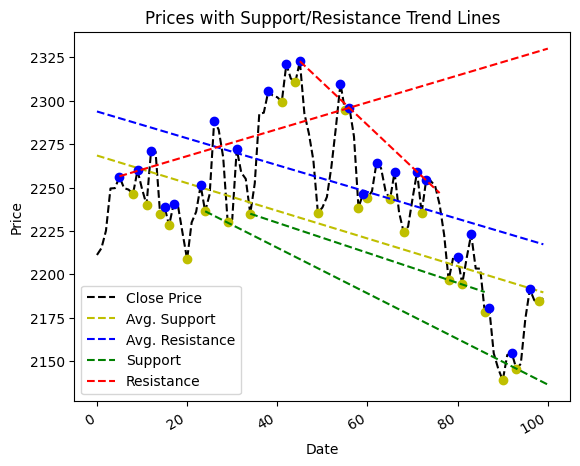

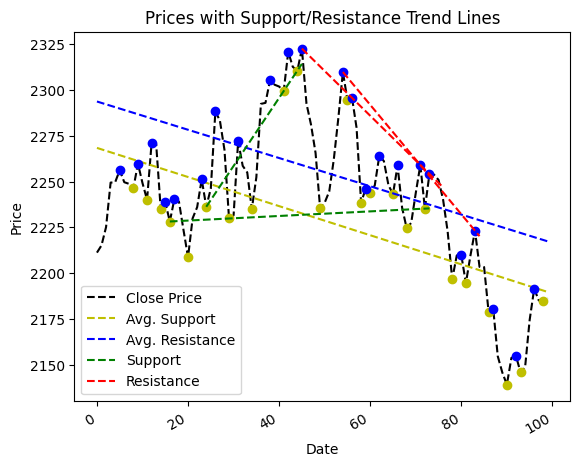

2


/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:452: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x != 0 and (mom[x-1] > 0 and mom[x] < 0 and h[x-1] < h[x] or #mom[x-1] < -mom[x] or
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:453: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mom[x-1] < 0 and mom[x] > 0 and h[x-1] > h[x])))] #-mom[x-1] < mom[x])))]
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:451: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

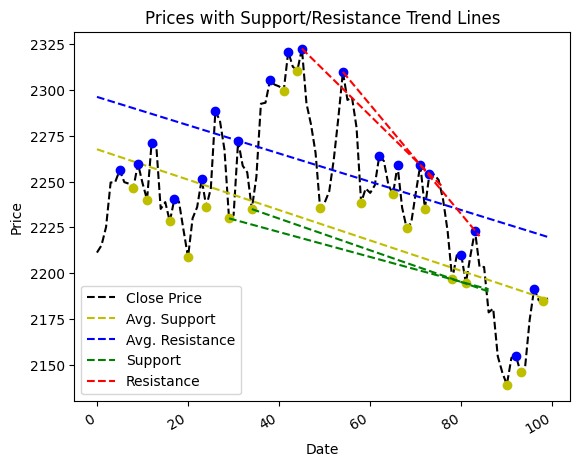

2


/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:538: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:548: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = get_bestfit([(p, h[p]) for p in CurIdxs])


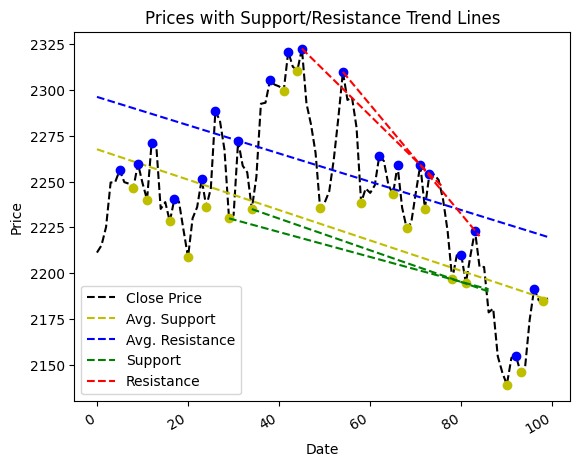

2
2


/home/vscode/.local/lib/python3.10/site-packages/trendln/__init__.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acc, theta, d = hough_points([(x, int((h[x] - m) * scl)) for x in Idxs], mx, len_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5))


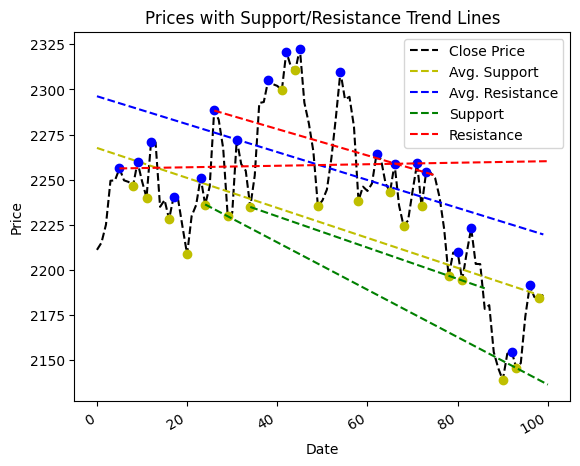

2


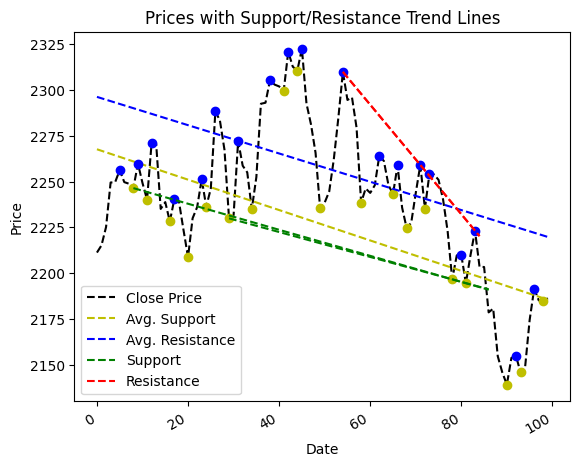

In [10]:
import trendln
import matplotlib.pyplot as plt
import itertools

data = get_data(["^OMX"])

for extmethod, method in itertools.product(range(3), range(5)):
    try:
        fig = trendln.plot_support_resistance(data["^OMX_Close"][-100:], accuracy=2, extmethod=extmethod, method=method)
    except Exception:
        continue
    plt.show()


#### Plotting the prices

INFO:data.loader:Dropping columns: "[]"


Index(['0P00011HBY.IR_Close', '0P00002BUP_Close', '0P0001Q77I.F_Close',
       '0P00000IAJ.ST_Close', '0P0001Q6FG.ST_Close', '0P00018OKM.ST_Close',
       '0P0000K9E7.ST_Close', '0P0001ECQR.ST_Close', '0P0001FU42.ST_Close',
       '0P00000K17.ST_Close'],
      dtype='object')


<Axes: xlabel='Date'>

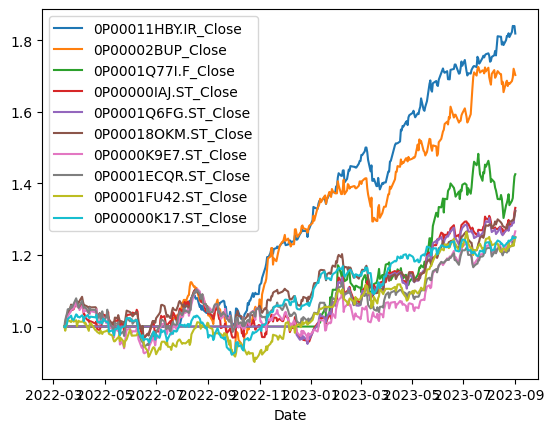

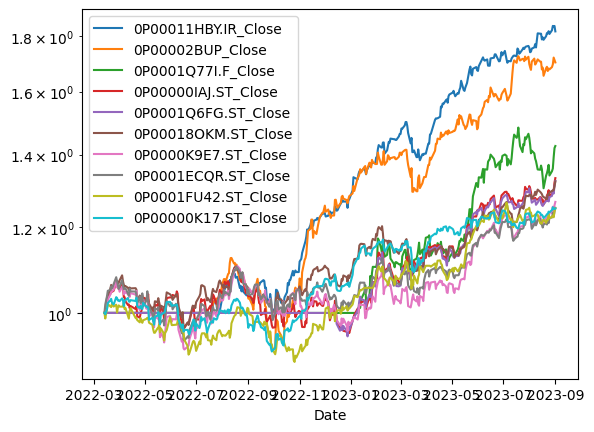

In [15]:
import matplotlib.pyplot as plt

data = get_data()

# Divide each column by the price at start date
data = data/data.iloc[0]

# Select only the columns with the higher last value
data = data[data.iloc[-1].sort_values(ascending=False).index[:10]]
print(data.columns)


data.plot()
data.plot(logy=True)

## Plot the correlation between the index and the stocks from the index

Look at the strongest and lowest correlation and plots the graphs side by side

INFO:data.loader:Dropping columns: "[]"


NameError: name 'plt' is not defined

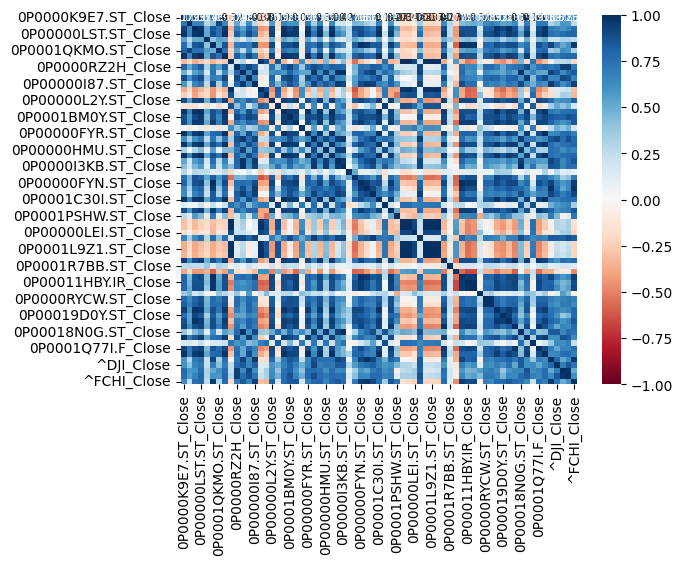

In [2]:
import seaborn as sns
import numpy as np
data = get_data()

# Divide each column by the price at start date
data = data/data.iloc[0]

# Remove the columns that have NaNs
data = data.dropna(axis=1)

corr = data.corr()


sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.show() 

#### Use a dendogram to visualize how the prices move together

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [65.0, 65.0, 75.0, 75.0],
  [42.5, 42.5, 70.0, 70.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [110.0, 110.0, 130.0, 130.0],
  [95.0, 95.0, 120.0, 120.0],
  [85.0, 85.0, 107.5, 107.5],
  [56.25, 56.25, 96.25, 96.25],
  [25.0, 25.0, 76.25, 76.25],
  [15.0, 15.0, 50.625, 50.625],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [215.0, 215.0, 225.0, 225.0],
  [192.5, 192.5, 220.0, 220.0],
  [255.0, 255.0, 265.0, 265.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [260.0, 260.0, 282.5, 282.5],
  [245.0, 245.0, 271.25, 271.25],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [258.125, 258.125, 312.5, 312.5],
  [235.0, 235.0, 285.3125, 285.3125],
  [335.0, 335.0, 345.0, 345.0],
  [260.15625, 260.15625, 340.0, 340.0],
  [206.25, 206.25, 300.078125, 300.078125],
  [170.0, 170.0, 253

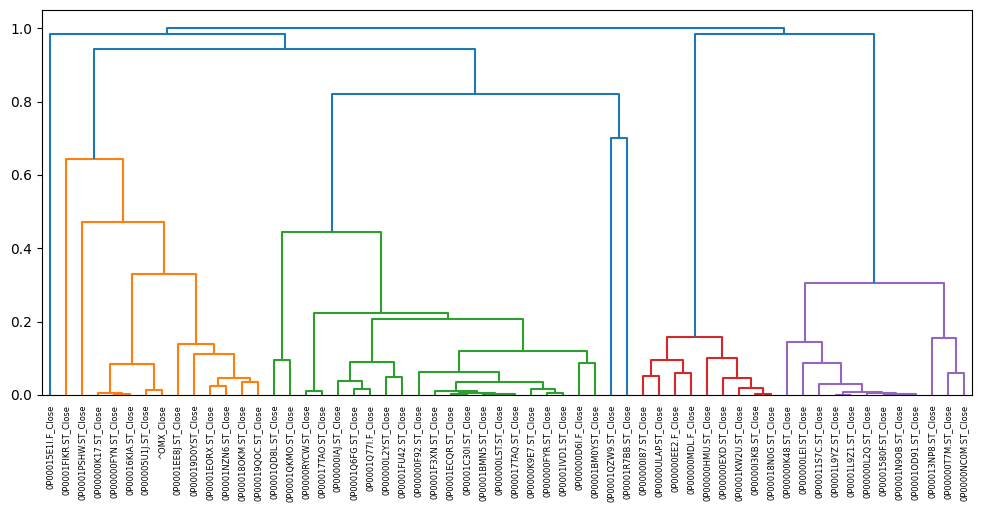

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(corr)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data.columns, orientation='top', 
           leaf_rotation=90)

#### Plot correlated prices

In [57]:
import seaborn as sns
import numpy as np
data = get_data()

# Divide each column by the price at start date
data = data/data.iloc[0]

# Remove the columns that have NaNs
data = data.dropna(axis=1)

corr = data.corr()

# Only keep the upper right triangle
# Set the upper right triangle to be zeros
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)

print(corr)

INFO:data.loader:Dropping columns: "['0P0000RZ2H_Close', '0P000151K0.F_Close', '0P00011HBY.IR_Close', '0P00002BUP_Close', '0P0001P9AO_Close', '^DJI_Close', '^IXIC_Close', '^GSPC_Close']"


                     0P0000K9E7.ST_Close  0P0001QD8L.ST_Close  \
0P0000K9E7.ST_Close                  NaN                  NaN   
0P0001QD8L.ST_Close             0.713998                  NaN   
0P0001EORX.ST_Close             0.925230             0.663355   
0P00000LST.ST_Close             0.965270             0.661292   
0P0001QZW9.ST_Close             0.531535             0.268167   
0P00000K17.ST_Close             0.757019             0.395053   
0P0001QKMO.ST_Close             0.799244             0.906064   
0P0001BMN5.ST_Close             0.968560             0.647468   
0P00000L2Q.ST_Close            -0.318021            -0.167863   
0P0001KW2U.ST_Close             0.480257             0.217151   
0P00000D6I.F_Close              0.890942             0.609806   
0P00000I87.ST_Close             0.579508             0.253779   
0P00011S7C.ST_Close            -0.380918            -0.190658   
0P00000K48.ST_Close            -0.244408            -0.075229   
0P00000L2Y.ST_Close      

Check the stocks the most correlated with the index over the last 5 years

In [58]:
corr_omx = corr['^OMX'].sort_values(ascending=False)

for k, (index, value) in enumerate(corr_omx.items()):
    plt.subplot(2,3,k+1)
    (data['^OMX']/(data['^OMX'].max())).plot()
    (data[index]/(data[index].max())).plot()
    plt.legend()
    plt.title(f'{index} - {value:.2f}')
    if k == 5:
        break
plt.tight_layout()
plt.show()

KeyError: '^OMX'

Check the stocks that are the less correlated

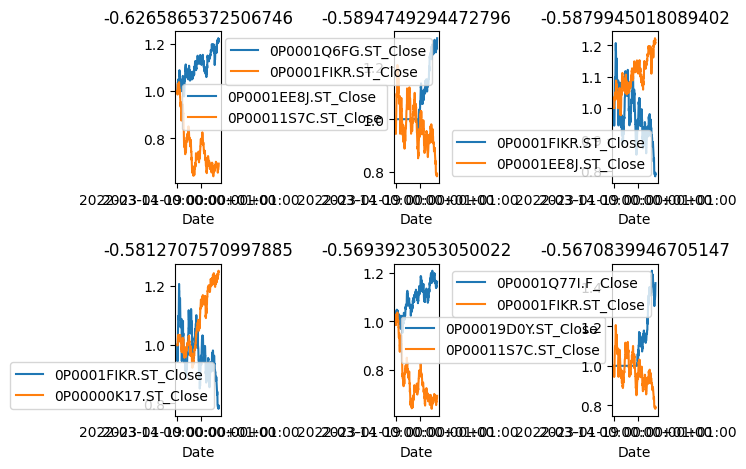

In [40]:
import numpy as np

corr_ = np.where(corr.isna(), 0, corr)

indices = np.argsort(corr_, axis=None)
indices = np.unravel_index(indices, corr_.shape)
indices = list(zip(*indices))

for k, index in enumerate(indices[:6]):
    plt.subplot(2,3, k+1)
    x, y = corr.index[index[0]], corr.columns[index[1]]
    data[x].plot()
    data[y].plot()
    plt.legend()
    plt.title(corr_[index])
plt.tight_layout()
plt.show()


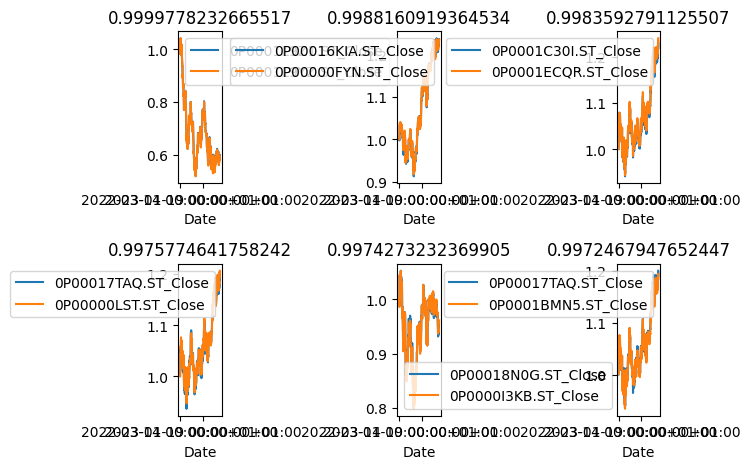

In [41]:
import numpy as np

corr_ = np.where(corr.isna(), 0, corr)

indices = np.argsort(corr_, axis=None)
indices = np.unravel_index(indices, corr_.shape)
indices = list(zip(*indices))

for k, index in enumerate(indices[::-1][:6]):
    plt.subplot(2,3, k+1)
    x, y = corr.index[index[0]], corr.columns[index[1]]
    data[x].plot()
    data[y].plot()
    plt.legend()
    plt.title(corr_[index])
plt.tight_layout()
plt.show()


## Compute the beta of the different stocks

In [42]:
# Importing libraries and packages
import statsmodels.api as sm
from statsmodels import regression
import pandas as pd

# Resample the data to monthly frequency
data_monthly = data.resample('m').last()

# Convert to percentage returns
data_monthly = data_monthly.pct_change()

# Remove the first row which is NaN
data_monthly.dropna(inplace=True)

# Get the column OMX_30 and remove it from the dataframe
omx = data_monthly['OMX_30']
data_monthly.drop(columns=['OMX_30'], inplace=True)

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()

    # We are removing the constant
    x = x[:, 1]
    return model.params[0], model.params[1]

betas = []
for ticker in data_monthly.columns:
    # Get the column for the ticker
    col = data_monthly[ticker]
    alpha, beta = linreg(omx.values, col.values)
    betas.append(beta)

# Create a dataframe with the tickers and betas
df_betas = pd.DataFrame()
df_betas['Ticker'] = data_monthly.columns
df_betas['Beta'] = betas

# Set the index to be the tickers
df_betas.set_index('Ticker', inplace=True)

df_betas.head()  


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

#### Visualize different average

In [43]:
data = get_data()
data.fillna(method='ffill', inplace=True)

data['^OMX'].plot()
# Compute the simple moving average
sma = data.rolling(200).mean()
sma['^OMX'].plot(label='sma200')
sma = data.rolling(50).mean()
sma['^OMX'].plot(label='sma50')

# Compute the exponential moving average
ema = data.ewm(span=12).mean()
ema['^OMX'].plot(label='ewm12')
ema = data.ewm(span=26).mean()
ema['^OMX'].plot(label='ewm26')

plt.legend()
plt.show()

INFO:data.loader:Dropping columns: "['0P0000RZ2H_Close', '0P000151K0.F_Close', '0P00011HBY.IR_Close', '0P00002BUP_Close', '0P0001P9AO_Close']"
/tmp/ipykernel_549/3694456201.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


KeyError: '^OMX'

#### Compute bollinger bands

/tmp/ipykernel_5089/1983619082.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_5089/1983619082.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{ticker}_TP'] = (
/tmp/ipykernel_5089/1983619082.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{ticker}_TP'] = (
/tmp/ipykernel_5089/1983619082.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is 

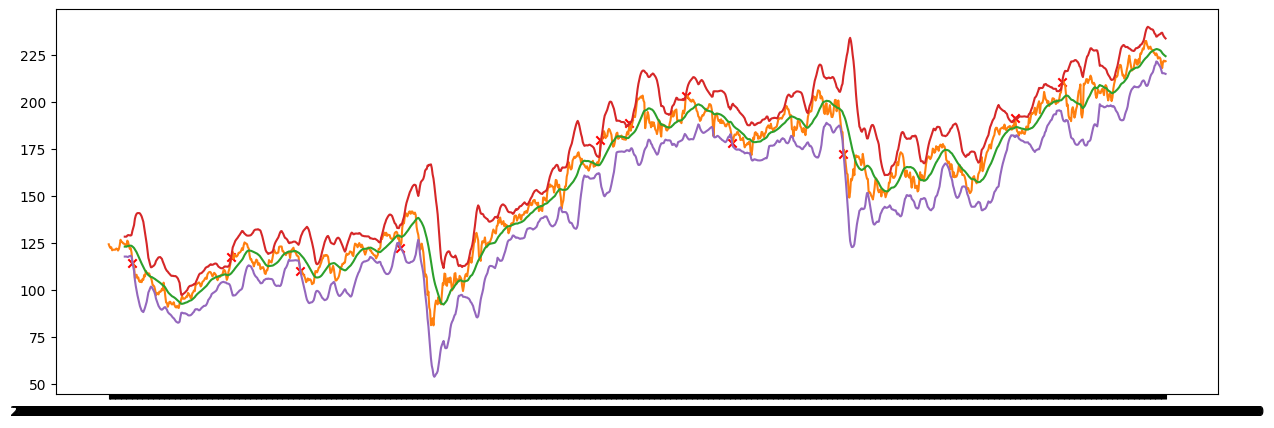

In [62]:
data = loader.get_dataframe(
    tickers_OMX,
    columns=['High', 'Low', 'Close'],
    start='2018-09-01',
    end='2023-09-01'
)

data.fillna(method='ffill', inplace=True)
for ticker in tickers_OMX:
    data[f'{ticker}_TP'] = (
        data[f'{ticker}_High'] + data[f'{ticker}_Low'] + data[f'{ticker}_Close']
    )/3


ticker = 'VOLV-B.ST'
close = f'{ticker}_Close'
tp = f'{ticker}_TP'
# Compute the simple moving average
sma = data.rolling(20).mean()
std = data.rolling(20).std()
bolu = sma + 3*std
bold = sma - 3*std

crossings = (data[close] > bolu[tp]) | (data[close] < bold[tp])
# Plot where the data points are out of the bollinger bands
data[close] = data[close][crossings]

plt.figure(figsize=(15,5))
plt.plot(data.index, data[close], label=close)
plt.plot(data.index, data[tp], label=tp)
plt.plot(data.index, sma[tp], label='sma20')
plt.plot(data.index, bolu[tp], label='bolu')
plt.plot(data.index, bold[tp], label='bold')
plt.scatter(data.index, data[close], marker='x', color='red', label='out of bands')
plt.show()

#### Compute a PCA on the correlation matrix

INFO:data.loader:Dropping columns: "[]"


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


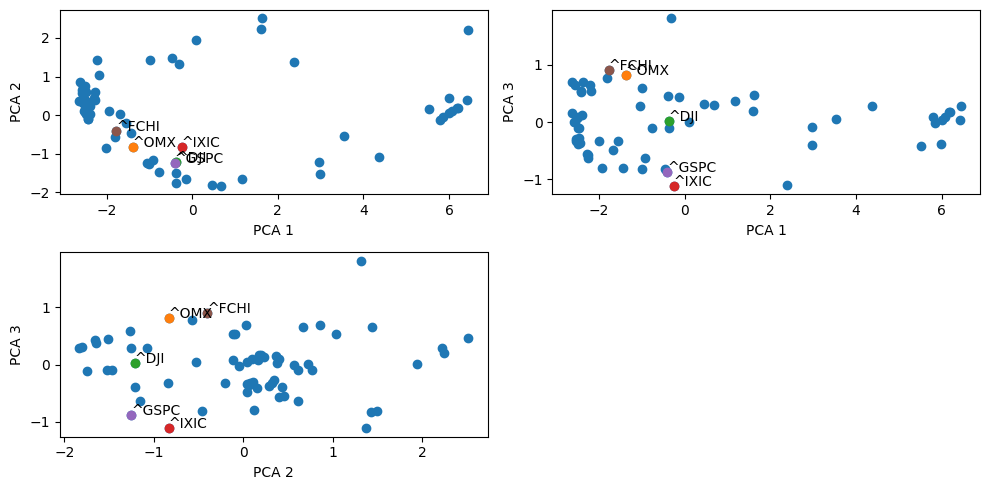

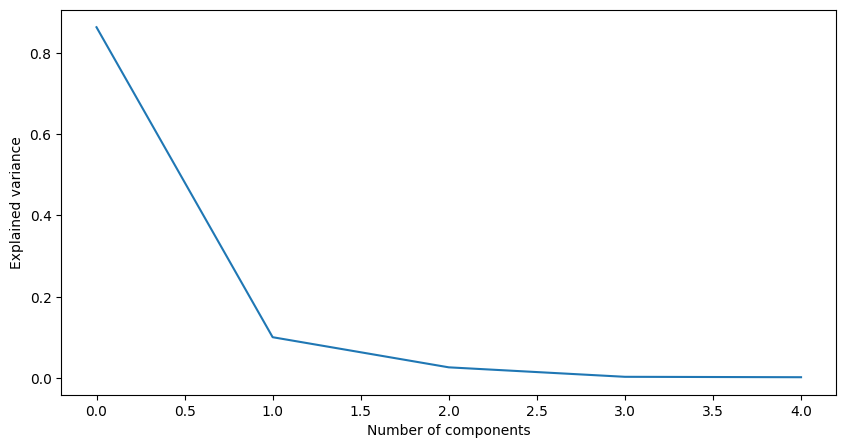

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


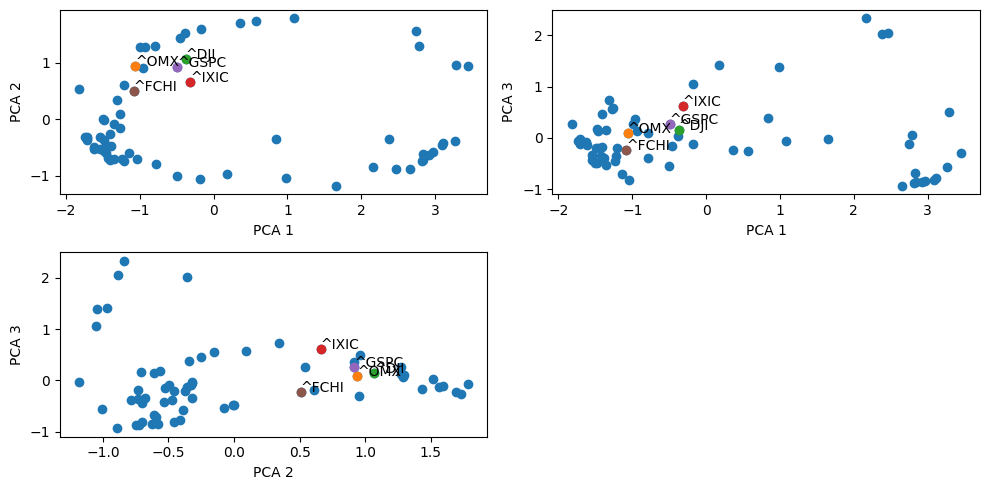

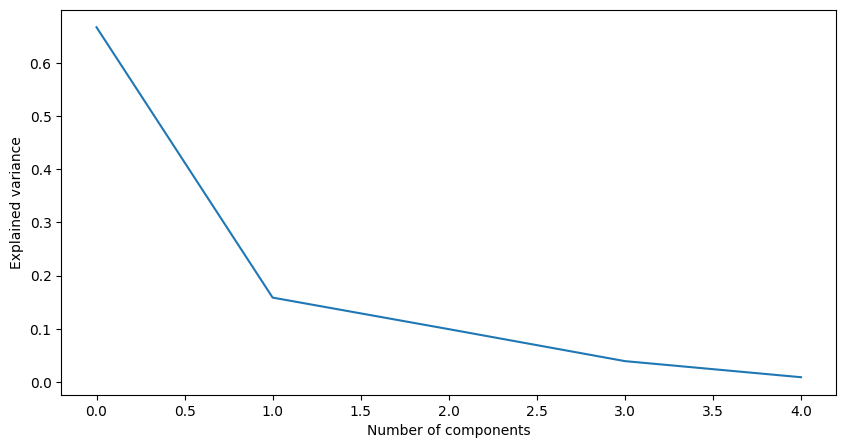

In [5]:
import itertools
data = get_data()

# Divide each column by the price at start date
data = data/data.iloc[0]

# Remove the columns that have NaNs
data = data.dropna(axis=1)

corr = data.corr()

# Perform a PCA on the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

correlation = corr
for corr in [correlation, np.abs(correlation)]:
    pca = PCA(n_components='mle', whiten=False)

    pca.fit(corr)
    data_pca = pca.transform(corr)

    range_i = 2
    range_j = 2

    indices_values = []
    for index in indices:
        value = corr[f"{index}_Close"].values
        value = value.reshape(1,-1)
        indices_values.append(pca.transform(value))

    plt.figure(figsize=(10,5))
    for k, (i, j) in enumerate(itertools.combinations([0,1,2], 2)):
        if i == j:
            continue
        plt.subplot(2, 2, k +1)
        
        plt.scatter(data_pca[:,i], data_pca[:,j])
        plt.xlabel(f'PCA {i+1}')
        plt.ylabel(f'PCA {j+1}')
        # Plot the point indices in different colors
        for index, value in zip(indices, indices_values):
            plt.scatter(value[:,i], value[:,j], label=index)
            plt.annotate(index, (value[:,i], value[:,j]))

    plt.tight_layout()
    plt.show()

    # Plot the eigenvalues
    plt.figure(figsize=(10,5))
    plt.plot(pca.explained_variance_ratio_[:5])
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    plt.show()